# Imports & Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import streamlit as st
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import requests
from io import StringIO
from pathlib import Path
from datetime import datetime
from dotenv import load_dotenv
from urllib.parse import urlencode

# Uncomment when ready for machine learning:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Pulling up our .env file:
load_dotenv()

True

# Data Preprocessing

## Object Declarations and Functions

In [4]:
# Function Sets and Parameters

function_set = ['TIME_SERIES_DAILY', 'RSI', 'NEWS_SENTIMENT', 'MACD']
single_function = ['NEWS_SENTIMENT']
sa_function_parameters = ['technology', 'retail_wholesale']
premium_function_set = ['MACD']

# A list of functions featured in the Alpha Vantage API and their parameters:
parameters = {
    'TIME_SERIES_DAILY': {
        'function': 'TIME_SERIES_DAILY',
        'symbol': None,
        'outputsize': 'full',
        'datatype': None,
        'apikey': None
        },
    'NEWS_SENTIMENT': {
        'function': 'NEWS_SENTIMENT',
        'tickers': None,
        'limit': 1000,
        'apikey': None
        },
    'RSI': {
        'function':'RSI',
        'symbol': None,
        'interval': 'daily',
        'time_period': 14,
        'series_type': 'close',
        'datatype': None,
        'apikey': None
        },
    'REAL_GDP': {
        'function': 'REAL_GDP',
        'interval':'quarterly',
        'datatype': None,
        'apikey': None
        },
    'MACD': {
        'function': 'MACD',
        'symbol': None,
        'interval': 'daily',
        'series_type':'close',
        'datatype': None,
        'apikey': None
    }
}

In [5]:
# Tracking (ONLY RUN THIS CELL ONCE PER SESSION)

session_calls = 0

In [6]:
# Machine Learning Objects

scaler = MinMaxScaler()
model = Sequential()

In [7]:
# Export CSV Function
#------
# Extracts a given DataFrame to a data folder within the working directory, appending a date value to the name of the DataFrame or
# a name passed as a string value.
#------

def export_csv(df, file_name: str = None):

    # Conditional to verify that "file_name" is a string:
    if not isinstance(file_name, str) and file_name is not None:
        raise TypeError(f'The "file_name" parameter must be a string or be left as NoneType; it\'s currently {str(type(file_name)).upper()}.')
    else:
        # Extracts the name of the DataFrame being passed if "file_name" is None.
        if file_name is None:
            for name, value in globals().items():
                if value is df:
                    file_name = name

    # Declares the current date:
    current_date = datetime.now().strftime('%Y-%m-%d')

    # Creates the data folder within the current working directory, utilizing a Path object that pulls the current working directory:
    path = Path('{}/data'.format(os.getcwd()))
    path.mkdir(parents=True, exist_ok=True)
    extract_to = '{}/{}_{}.csv'.format(path, current_date, file_name)

    # Exports the CSV file:
    df.to_csv(extract_to)

    return print('> Exported your DataFrame to \'{}\'!'.format(extract_to))

In [8]:
# Generate Features Function
#------
# Generates different lagged close, rolling mean/std and relative change features
# for the daily time series data. Appled in Data Prep Function.
#------

def generate_features(df):

    # Declaring the location of the close column; to insert the new features next it:
    close_location = df.columns.get_loc('close')

    # Lagged Close
    df.insert(close_location + 1, 'lag_1', df['close'].shift(1))
    df.insert(close_location + 2, 'lag_2', df['close'].shift(2))

    # Windowed Mean and STD
    df.insert(close_location + 3, 'rolling_mean_7', df['close'].rolling(window=7).mean())
    df.insert(close_location + 4, 'rolling_std_7', df['close'].rolling(window=7).std())

    # Relative Change
    df.insert(close_location + 5, 'daily_return', df['close'].pct_change() * 100)

    # Drops any rows with resulting null values:
    df.dropna(inplace=True)

    return df

In [9]:
# Data Prep Function
#------
# One stop shop to prep data so that it can be fit into a machine learning algorithm.
#------

def prep_data(df, target: list|tuple|set|str, n_steps: int=3, test_size: float=0.3, random_state: int=40):

    # Generating lagged close, rolling mean
    df = generate_features(df)

    X = df.drop(columns=target)
    y = df[target].values.reshape(-1, 1)

    X = scaler.fit_transform(X)
    y = scaler.fit_transform(y)

    # Declaring lists to store sequenced data in accordance with "n_steps" value:
    X_sequenced, y_sequenced = [], []

    # The loop that appends the sequenced feature and target data:
    for i in range(len(X) - n_steps):
        X_sequenced.append(X[i:i+n_steps])
        y_sequenced.append(y[i + n_steps])

    # Converting sequenced data into NumPy arrays:
    X = np.array(X_sequenced)
    y = np.array(y_sequenced).reshape(-1, 1)

    # Splitting data:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    print('> Features generated, target extracted, data normalized, sequenced, split and returned successfully!')

    return X_train, X_test, y_train, y_test

In [10]:
# Sentiment Extraction Function
#------
# Applied to the resulting DataFrame from the "NEWS_SENTIMENT" function to extract useful data.
#------

def extract_sentiment(df, symbol: str):

    # Conditional to verify that "symbol" is a string:
    if not isinstance(symbol, str):
        raise TypeError(f'The "symbol" parameter must be a string; it\'s currently {str(type(symbol)).upper()}.')

    # Declaration of an empty DataFrames for extracting data and merging before return:
    df_time = pd.DataFrame(columns=['id', 'time_published'])
    df_sentiment = pd.DataFrame(columns=['id', 'relevance_score', 'ticker_sentiment_score', 'ticker_sentiment_label'])

    # Declaring the amount of returned articles to be looped over:
    count = df.shape[0]

    # Loop that pulls the "time_published", "relevance_score", "ticker_sentiment_score", and "ticker_sentiment_label" for the given stock symbol
    # from every row of the "NEWS_SENTIMENT" DataFrame:
    for id in range(count):
        time_row = pd.DataFrame({
            'id': [id],
            'time_published': [df.loc[id, 'feed']['time_published']]
        })
        df_time = pd.concat([df_time, time_row], ignore_index=True)
        for sentiment in df.loc[id, 'feed']['ticker_sentiment']:
            if sentiment['ticker'] == symbol:
                sentiment_row = pd.DataFrame({
                    'id': [id],
                    'relevance_score': [sentiment['relevance_score']],
                    'ticker_sentiment_score':[sentiment['ticker_sentiment_score']],
                    'ticker_sentiment_label': [sentiment['ticker_sentiment_label']]
                })
                df_sentiment = pd.concat([df_sentiment, sentiment_row], ignore_index=True)

    merged_df = df_time.merge(df_sentiment, on='id').drop(columns='id')

    return merged_df

In [11]:
# TimeSeries Indexer
#------
# Applied to every DataFrame produce by an API call.
#------

def set_time_index(df):

    for column in df.columns:
        if str(column).startswith('time') or str(column).endswith('time'):
            df.set_index(pd.to_datetime(df[column]).dt.date, inplace=True)
            df.sort_index(inplace=True)
            df.drop(columns=column, inplace=True)
            df.index.name = 'time'

    return df

In [12]:
# Data Import Function
# ------
# Can create a tuple of DataFrames indexed on a TimeSeries, ready to be processed and merged into a train/test split.
# ------

def alpha_supercall(function_set: str|tuple|list|set, symbol: str, datatype: str, base_query='https://www.alphavantage.co/query?', apikey=os.getenv('ALPHAVANTAGE_API_KEY')):

    # Conditional to verify that "function_set" is either a single string value or iterable of strings:
    if isinstance(function_set, str):
        function_string = function_set
        function_set = []
        function_set.append(function_string)
    elif isinstance(function_set, (int, float, bool)):
        raise TypeError(f'The "function_set" parameter either needs to be a single function passed as a string or an iterable set of strings.\nFUNCTION_SET: {str(type(function_set)).upper()}')
    else:
        if not all(isinstance(item, str) for item in function_set):
            raise TypeError('All items in "function_set" must be string values of the function you\'d like to call.')

    # Conditional to verify that "symbol" and "datatype" are strings:
    if not isinstance(symbol, str) or not isinstance(datatype, str):
        raise TypeError(f'Both the "symbol" and "datatype" parameters must be strings.\nSYMBOL: {str(type(symbol)).upper()}\nDATATYPE: {str(type(datatype)).upper()}')

    # Allow the user to enter a symbol in lowercase without breaking the call:
    symbol = symbol.upper()

    # DataFrame list to be converted to a tuple before being returned to the user:
    dataframes = []

    # Counter for number of calls made to the API in a single function call:
    calls = 0

    for function in function_set:

        # In case a lowercase function is passed:
        function = function.upper()

        # Applies the API key to each function being called:
        parameters[function]['apikey'] = apikey

        # The first set of conditionals that checks the "parameters" dictionary and verifies if "symbol" and "datatype" keys are present
        # within the nested function dictionary, setting them accordingly:
        if 'symbol' and 'datatype' in parameters[function].keys():
            parameters[function]['symbol'] = symbol
            parameters[function]['datatype'] = datatype
        elif 'symbol' not in parameters[function].keys() and 'datatype' in parameters[function].keys():
            parameters[function]['datatype'] = datatype
        else:
            parameters[function]['symbol'] = symbol

        # The second set of conditionals that checks the function type:

        # The "NEWS_SENTIMENT" function only returns JSON with a ton of data that isn't relevant to a prediction model,
        # this conditional statement passes the resulting DataFrame from a "NEWS_SENTIMENT" call
        # through Sentiment Extraction Function:
        if function == 'NEWS_SENTIMENT':
            parameters[function]['tickers'] = symbol
            # Uncomment OPTION 1 and recomment OPTION 2 if you don't want to extract the sentiment and want the pure JSON dictionary:
            # df = pd.DataFrame(requests.get(base_query + urlencode(parameters[function])).json())                              # OPTION 1
            df = extract_sentiment(pd.DataFrame(requests.get(base_query + urlencode(parameters[function])).json()), symbol)     # OPTION 2 (DEFAULT)
            calls += 1
            df = set_time_index(df)
            dataframes.append(df)
            print(f'> "{function}" DataFrame created! -- SHAPE: {df.shape}')
        else:
            df = pd.read_csv(StringIO(requests.get(base_query + urlencode(parameters[function])).text))
            calls += 1
            df = set_time_index(df)
            dataframes.append(df)
            print(f'> "{function}" DataFrame created! -- SHAPE: {df.shape}')

    global session_calls
    session_calls += calls

    # Prints the amount of API calls made in the function call and the total calls made in the current session:
    print(f'\nCALL WEIGHT: {calls}')
    print(f'TOTAL CALLS MADE: {session_calls}')

    # Returns a single DataFrame if only one function is passed:
    if len(function_set) == 1:
        return dataframes[0]

    # Returns a tuple to unpack into multiple DataFrames if multiple functions are passed:
    else:
        return tuple(dataframes)

## First Set

In [13]:
aapl_tsd, aapl_rsi, aapl_ns, aapl_macd = alpha_supercall(function_set, 'AAPL', 'csv')

> "TIME_SERIES_DAILY" DataFrame created! -- SHAPE: (6143, 5)
> "RSI" DataFrame created! -- SHAPE: (6129, 1)
> "NEWS_SENTIMENT" DataFrame created! -- SHAPE: (686, 3)
> "MACD" DataFrame created! -- SHAPE: (6110, 3)

CALL WEIGHT: 4
TOTAL CALLS MADE: 4


In [14]:
aapl_tsd.head()

,open,high,low,close,volume
time,,,,,
1999-11-01,80.00,80.69,77.37,77.62,2487300
1999-11-02,78.00,81.69,77.31,80.25,3564600
1999-11-03,81.62,83.25,81.00,81.50,2932700
1999-11-04,82.06,85.37,80.62,83.62,3384700
1999-11-05,84.62,88.37,84.00,88.31,3721500


In [15]:
aapl_rsi.head()

,RSI
time,
1999-11-19,69.9838
1999-11-22,66.4703
1999-11-23,68.5184
1999-11-24,70.2012
1999-11-26,70.5350


In [16]:
aapl_macd.head()

,MACD,MACD_Hist,MACD_Signal
time,,,
1999-12-17,0.0243,-0.0174,0.0417
1999-12-20,0.0211,-0.0165,0.0376
1999-12-21,0.0211,-0.0132,0.0343
1999-12-22,0.0193,-0.0120,0.0313
1999-12-23,0.0198,-0.0092,0.0290


In [17]:
aapl = aapl_tsd.merge(aapl_rsi, left_index=True, right_index=True) \
    .merge(aapl_macd, left_index=True, right_index=True)

In [18]:
aapl.shape

(6110, 9)

In [19]:
# export_csv(aapl)

In [20]:
aapl_X_train, aapl_X_test, aapl_y_train, aapl_y_test = prep_data(aapl, 'close', 4, random_state=56)

> Features generated, target extracted, data normalized, sequenced, split and returned successfully!


In [21]:
model.add(LSTM(units=50, activation='relu', input_shape=(4, aapl_X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

Epoch 1/40
121/121 [==============================] - 1s 2ms/step - loss: 0.0087 - val_loss: 6.8725e-04
Epoch 2/40
121/121 [==============================] - 0s 1ms/step - loss: 5.0204e-04 - val_loss: 4.9025e-04
Epoch 3/40
121/121 [==============================] - 0s 1ms/step - loss: 4.6001e-04 - val_loss: 3.8407e-04
Epoch 4/40
121/121 [==============================] - 0s 1ms/step - loss: 4.1327e-04 - val_loss: 3.3387e-04
Epoch 5/40
121/121 [==============================] - 0s 1ms/step - loss: 3.9446e-04 - val_loss: 3.0749e-04
Epoch 6/40
121/121 [==============================] - 0s 1ms/step - loss: 3.8295e-04 - val_loss: 4.0210e-04
Epoch 7/40
121/121 [==============================] - 0s 1ms/step - loss: 3.8394e-04 - val_loss: 2.5539e-04
Epoch 8/40
121/121 [==============================] - 0s 1ms/step - loss: 3.8868e-04 - val_loss: 2.4659e-04
Epoch 9/40
121/121 [==============================] - 0s 1ms/step - loss: 3.8684e-04 - val_loss: 2.3205e-04
Epoch 10/40
121/121 [===========

In [29]:
history = model.fit(aapl_X_train, aapl_y_train, epochs=80, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/80
121/121 [==============================] - 0s 1ms/step - loss: 3.2882e-04 - val_loss: 1.3482e-04
Epoch 2/80
121/121 [==============================] - 0s 996us/step - loss: 3.3318e-04 - val_loss: 1.0101e-04
Epoch 3/80
121/121 [==============================] - 0s 1ms/step - loss: 2.9636e-04 - val_loss: 0.0022
Epoch 4/80
121/121 [==============================] - 0s 1ms/step - loss: 0.0016 - val_loss: 1.6559e-04
Epoch 5/80
121/121 [==============================] - 0s 1ms/step - loss: 3.0953e-04 - val_loss: 1.1248e-04
Epoch 6/80
121/121 [==============================] - 0s 1ms/step - loss: 3.0463e-04 - val_loss: 1.1897e-04
Epoch 7/80
121/121 [==============================] - 0s 996us/step - loss: 3.0857e-04 - val_loss: 1.0378e-04
Epoch 8/80
121/121 [==============================] - 0s 1ms/step - loss: 3.0241e-04 - val_loss: 1.0289e-04
Epoch 9/80
121/121 [==============================] - 0s 1ms/step - loss: 3.0444e-04 - val_loss: 1.0620e-04
Epoch 10/80
121/121 [===========

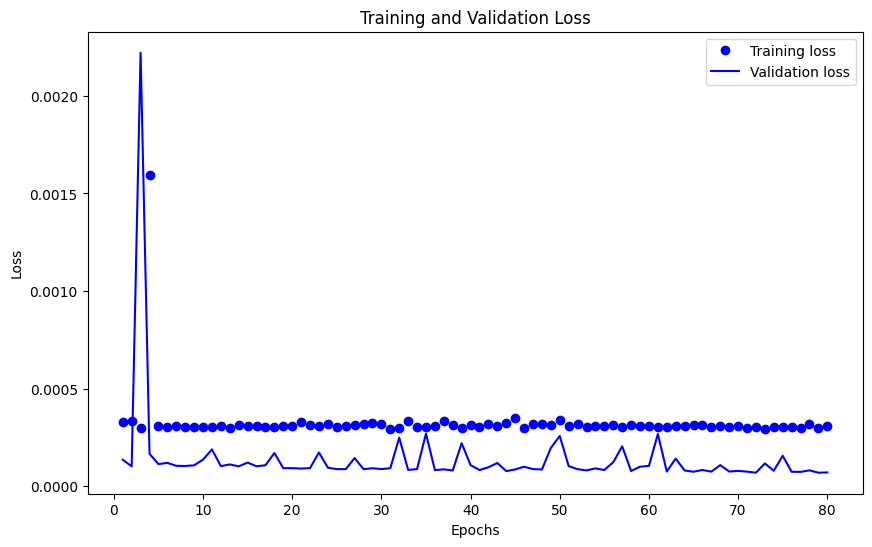

In [30]:
# Extracting loss and validation loss from the history object
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

# Plotting the loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, 'bo', label='Training loss')  # 'bo' gives us blue dot
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # 'b' gives us solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


## Second Set

In [22]:
msft_tsd, msft_rsi, msft_ns, msft_macd = alpha_supercall(function_set, 'msft', 'csv')

> "TIME_SERIES_DAILY" DataFrame created! -- SHAPE: (6143, 5)
> "RSI" DataFrame created! -- SHAPE: (6129, 1)
> "NEWS_SENTIMENT" DataFrame created! -- SHAPE: (709, 3)
> "MACD" DataFrame created! -- SHAPE: (6110, 3)

CALL WEIGHT: 4
TOTAL CALLS MADE: 8


In [23]:
msft_tsd.head()

,open,high,low,close,volume
time,,,,,
1999-11-01,93.25,94.19,92.12,92.37,26630600
1999-11-02,92.75,94.50,91.94,92.56,23174500
1999-11-03,92.94,93.50,91.50,92.00,22258500
1999-11-04,92.31,92.75,90.31,91.75,27119700
1999-11-05,91.81,92.87,90.50,91.56,35083700


In [24]:
msft = msft_tsd.merge(msft_rsi, left_index=True, right_index=True) \
    .merge(msft_macd, left_index=True, right_index=True)

In [25]:
msft.shape

(6110, 9)

In [26]:
# export_csv(msft)

In [27]:
msft_X_train, msft_X_test, msft_y_train, msft_y_test = prep_data(msft, 'close', 4, random_state=32)

> Features generated, target extracted, data normalized, sequenced, split and returned successfully!
